# Decision trees on iris dataset

The iris dataset contains sepal length, sepal width, petal length and petal width for classifying flowers between 3 classes. 

Here, we will be using decision trees to classify a given input into one of the 3 classes.

---

## Importing libraries and data pre-processing

Libraries :
- sklearn
  - Importing iris dataset
  - Splitting dataset into train and test sets
- pandas
  - Dataset is stored as pandas dataframe
- numpy
- matplotlib
  - For visualisation
- Ipython.display
  - For showing pandas Dataframes neatly

In [1]:
# sklearn for only the dataset, pandas for managing the dataset and numpy for processing
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from time import time

from IPython.display import display
import matplotlib.pyplot as plt

### About the dataset


In [21]:
# Importing the dataset
data = load_iris()

x = data['data']
y = data['target']
col_names = data['feature_names']

x = pd.DataFrame(x, columns=col_names)
display(x)
x['target'] = y

tgt_types = x['target'].unique()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


/home/ashwin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


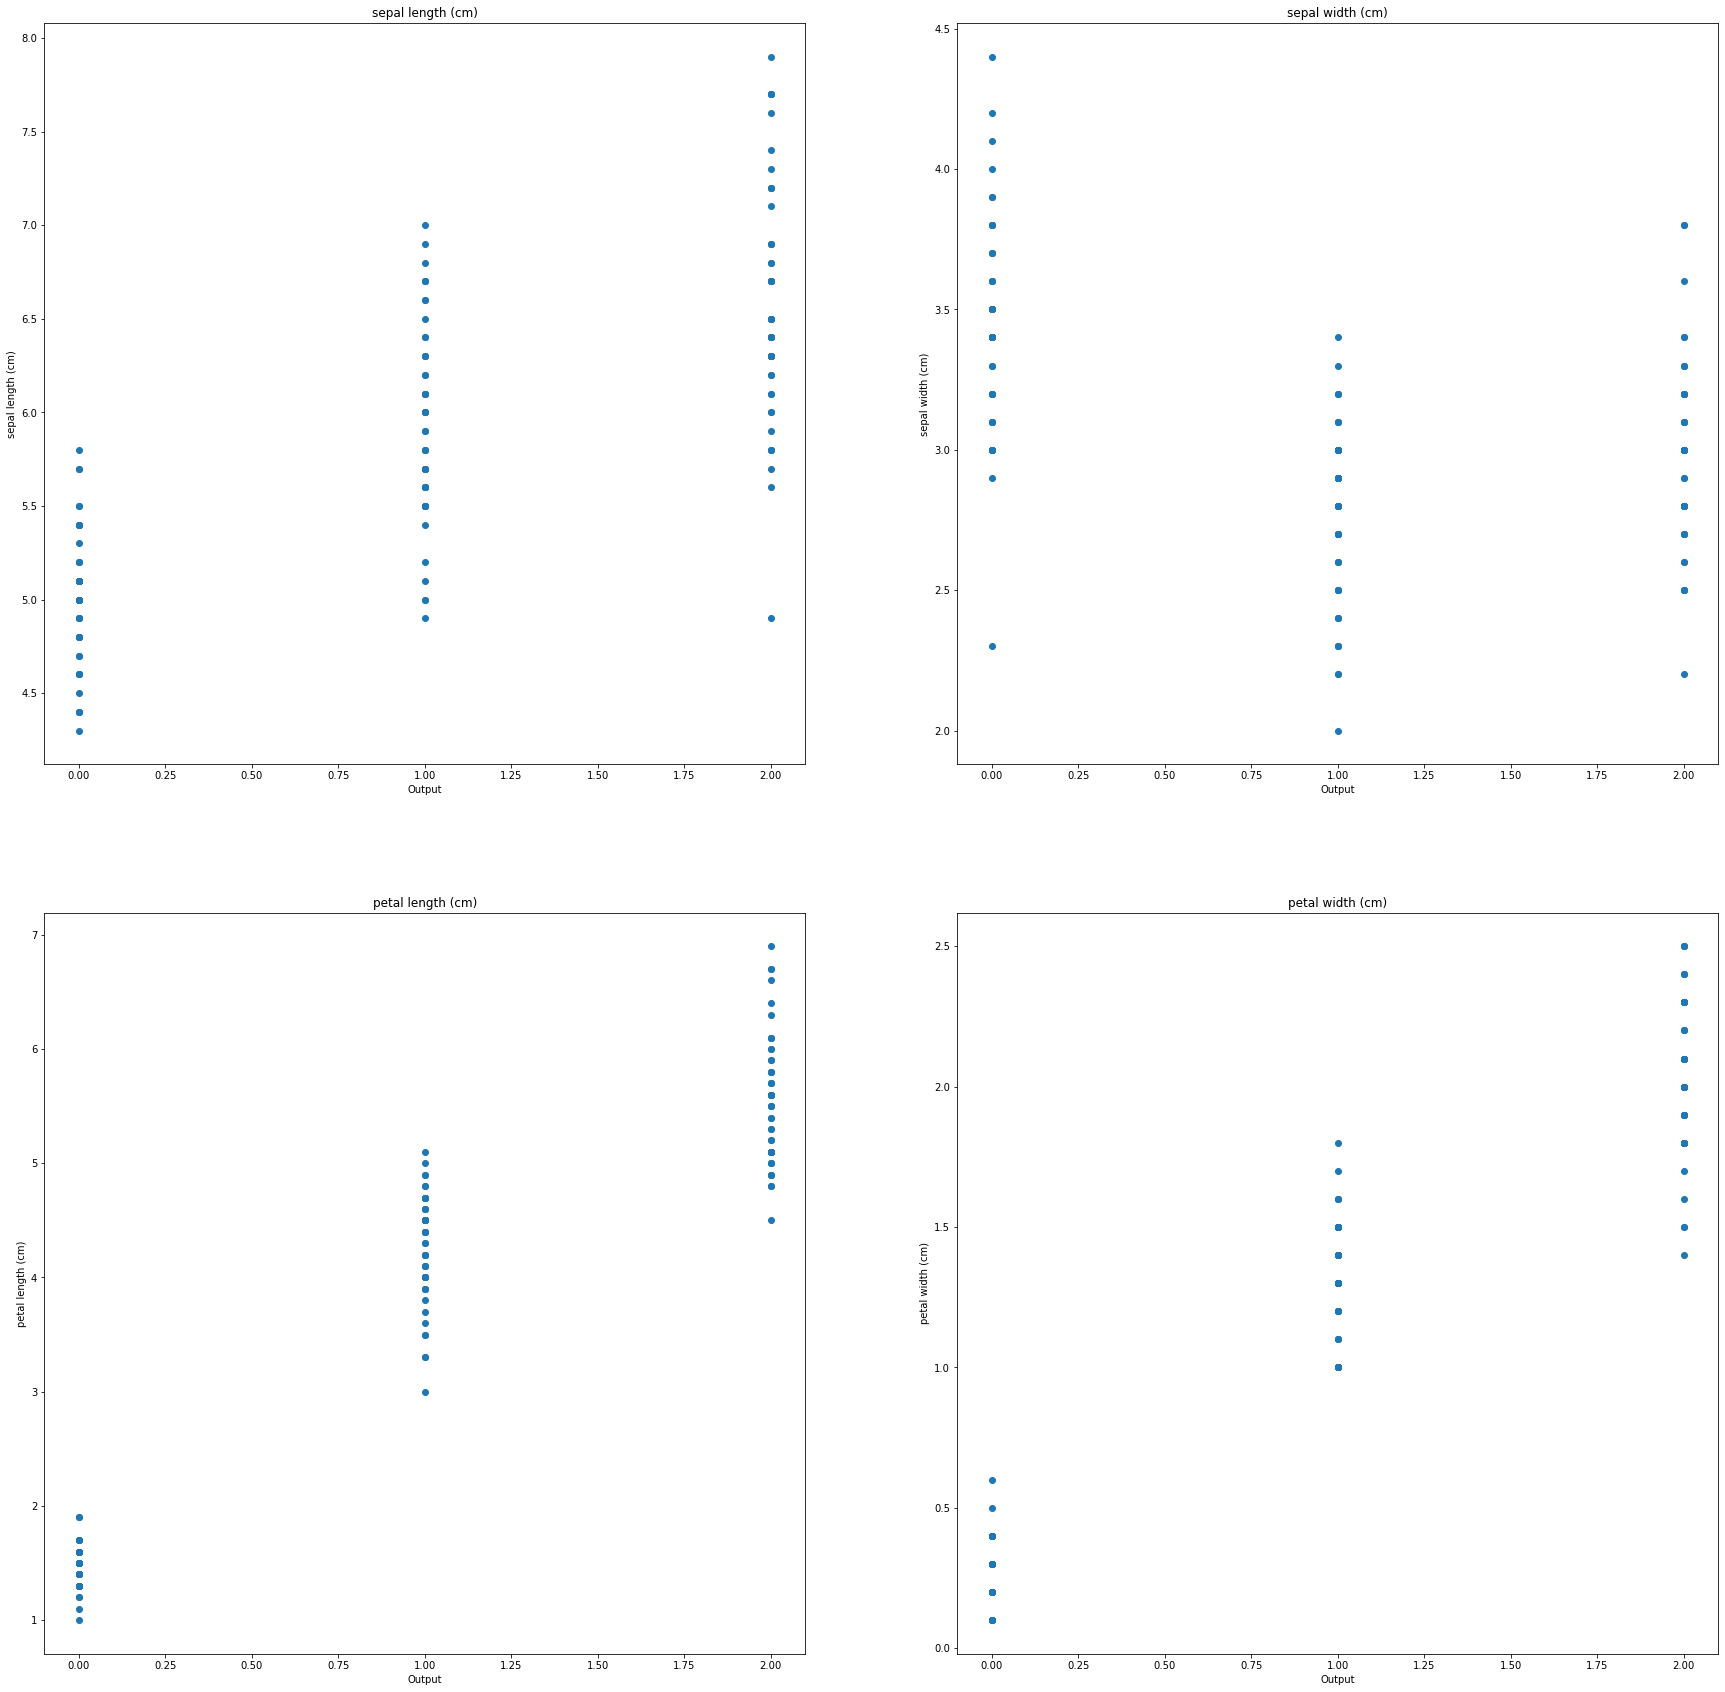

In [22]:
col_num = len(col_names)
plt_dim = np.ceil(np.sqrt(col_num))
plt.figure(figsize=(30, 30))
for i in range(col_num):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.title(col_names[i])
    plt.ylabel(col_names[i])
    plt.xlabel('Output')
    plt.scatter(x['target'], x[col_names[i]])
plt.show()

In [3]:
# Splitting the dataset
train, test = train_test_split(x, test_size=20)

## The code!
I have used an object-oriented approach, and have implemented a class for each node in the decision tree (inspired by keras and pytorch APIs). The tree is build using a recursive breadth-first search algorithm, while simultaneously fitting the data.

In [4]:
def gini(x, col_name=None, thresh_val=None, debug=False):
    
    if(col_name == None):
        tot_no = x.shape[0]
        class_loss = np.zeros((tgt_types.size,1))
        
        for i in range(tgt_types.size):
            class_no = x.loc[x['target'] == tgt_types[i]].shape[0]
            class_p  = class_no / tot_no
            class_loss[i, 0] = class_p * (1 - class_p)

        return sum(class_loss)

    upper = x.loc[x[col_name] >  thresh_val]
    lower = x.loc[x[col_name] <= thresh_val]


    class_loss = np.zeros((tgt_types.size, 2))

    upper_tot = upper.shape[0]   
    lower_tot = lower.shape[0] 

    if(upper_tot == 0 or lower_tot == 0):
        return 1

    for i in range(tgt_types.size):
        upper_cls_no = upper.loc[upper['target'] == tgt_types[i]].shape[0]
        lower_cls_no = lower.loc[lower['target'] == tgt_types[i]].shape[0]
        
        upper_cls_p  = upper_cls_no / upper_tot
        lower_cls_p  = lower_cls_no / lower_tot

        class_loss[i, 0] = upper_cls_p * (1 - upper_cls_p)
        class_loss[i, 1] = lower_cls_p * (1 - lower_cls_p)

    gini = np.sum(class_loss, axis=0)

    impurity = (upper_tot*gini[0]/x.shape[0]) + (lower_tot*gini[1]/x.shape[0])

    if debug:
        plt.scatter(upper[col_name], upper['target'], color="green")
        plt.scatter(lower[col_name], lower['target'], color="blue")
        plt.ylabel("Class")
        plt.xlabel(col_name)
        plt.axline((thresh_val, 0), (thresh_val, 2))
        plt.title("Split : %.2f, Impurity : %.3f"%(thresh_val, impurity))
        plt.show()

        
    return impurity

In [5]:
def split_data(x, col_name, thresh):
    upper = x.loc[x[col_name] > thresh].drop(col_name, axis=1)
    lower = x.loc[x[col_name] <= thresh].drop(col_name, axis=1)

    return (upper, lower)

In [6]:
def find_best_split(x):
    inputs = x.drop('target', axis=1)
    outputs = x['target']
    
    min_impurity = 1
    min_col = ""
    min_thresh = -1

    for col_name in inputs.columns:

        values = x.sort_values(col_name)[col_name].unique()
        thresholds = [(values[i]+values[i+1])/2 for i in range(values.shape[0]-1)]

        for i in thresholds:
            impurity = gini(x, col_name, i, False)

            if(impurity < min_impurity):
                min_impurity = impurity
                min_col      = col_name
                min_thresh   = i

    return (min_impurity, min_col, min_thresh)

In [7]:
class DecisionNode():
    def __init__(self, parent, level=None, name=None, debug=False):
        self.parent = parent
        
        if(level == None):
            if(parent == None):
                self.level = 0
            else:
                self.level = parent.level + 1
        else:
            self.level = level
        
        self.leaf   = False             # Is this node a leaf node?
        self.state  = None              # The output state (if a leaf node)
        self.col    = None              # Threshold column name
        self.thresh = 0                 # Threshold value
        
        self.upper  = None              # Upper child node
        self.lower  = None              # Lower child node

        self.debug  = debug             # If true, displays debug information

        if(name == None):               # The name is displayed if debug is turned on
            if(parent == None):
                self.name = "root_node"
            else:
                self.name = "level%d_node" % self.level
        else:
            self.name = name

        if(debug):
            print(" %15s : Initialised node with level : %2d" % (self.name, self.level))

    # Turn the node into a leaf node, with provided output
    def make_leaf(self, output):
        self.leaf  = True
        self.state = output

        if(self.debug):
            print(" %15s : Made into leaf node, with output '%d'" % (self.name, self.state))

    # Train with data (set column and threshold).
    # If the gini impurity has deteriorated or has not improved, then the node is made into a leaf node.
    # force_decision can be set to True to disable automatic conversion to leaf nodes
    def train(self, x, force_decision=False):
        data_impurity = gini(x)
        impurity, self.col, self.thresh = find_best_split(x)

        if(self.debug):
            print(" %15s : Trained. Impurity before : %.2f, Impurity : %.2f, Column : '%s', Threshold : %.2f" % (self.name, data_impurity, impurity, self.col, self.thresh))
        
        if(impurity >= data_impurity and not force_decision):
            self.make_leaf(x.mode()['target'][0])
            self.col    = None
            self.thresh = None

    # Split the data into two, if its not a leaf node
    def split(self, x):
        if(self.leaf):
            if(self.debug):
                print(" %15s : Cant split, is a leaf node."%self.name)
            return False

        if(self.debug):
            print(" %15s : Splitting input..."%self.name)
        
        return split_data(x, self.col, self.thresh)
    
    # Attach the upper child node
    def attach_upper(self, upper_node):
        if(self.leaf):
            print(" %15s : Cant attach, is a leaf node"%self.name)
            return False
        
        self.upper = upper_node
        return True

        if(self.debug):
            print(" %15s : Attached upper node '%s'"%(self.name, self.upper.name))

    # Attach the lower child node
    def attach_lower(self, lower_node):
        if(self.leaf):
            print(" %15s : Cant attach, is a leaf node"%self.name)
            return False

        self.lower = lower_node
        return True

        if(self.debug):
            print(" %15s : Attached upper node '%s'"%(self.name, self.lower.name))

    # Classify a given data sample
    # If the node is a leaf node, it returns the assigned state
    # Else, it uses the decision criteria to call either the upper or lower child node.
    def classify(self, x):
        if(self.leaf):
            if(self.debug):
                print(" %15s : Leaf node - returning result %d"%(self.name, self.state))
            return self.state

        if(self.debug):
            print(" %15s : Classifying criteria - %s >= %.2f"%(self.name, self.col, self.thresh))
        if(x[self.col] > self.thresh):
            if(self.debug):
                print(" %15s : Moving to upper node"%self.name)
            return self.upper.classify(x)
        else:
            if(self.debug):
                print(" %15s : Moving to lower node"%self.name)
            return self.lower.classify(x)

    # Create and link upper and lower child nodes
    def make_children(self, debug=None):
        if(self.debug):
            print(" %15s : Making children nodes..."%self.name)

        if(debug==None):
            debug=self.debug

        upper = DecisionNode(self, name='%s+'%(self.name), debug=debug)
        lower = DecisionNode(self, name='%s-'%(self.name), debug=debug)

        self.attach_upper(upper)
        self.attach_lower(lower)

        return upper, lower

    # Returns the upper and lower child nodes
    def get_children(self):
        return self.upper, self.lower

    # Change debug state.
    # Setting propagate to True will propagate the change in debug state down its child nodes.
    def set_debug(self, debug=True, propagate=False):
        if(self.debug != debug):
            print(" %15s : Setting debug to %s"%(self.name, debug))
        self.debug=debug
        if(propagate):
            if(not self.leaf):
                self.upper.set_debug(debug, True)
                self.lower.set_debug(debug, True)

In [8]:
# Recurseive depth-first search, while building the tree
def build_tree(data, level, node=None, debug=False):
    # If at the last level, make the node a leaf node
    if(level == 0):
        leaf_out = data.mode()['target'][0]
        node.make_leaf(leaf_out)
        return
    
    # If no parent node is passed, create a new node, called the 'root' node.
    if(node == None):
        node = DecisionNode(None, name='root', debug=debug)
    
    # Train the node
    node.train(data)
    
    # If the node decided to be a leaf node, stop building further
    if(node.leaf):
        return

    # Else, make child nodes, and split the dataset between these nodes
    node.make_children()
    upper_ds, lower_ds = node.split(data)
    
    # Build the tree down from these nodes, using the split dataset.
    # Note : Its a depth-first search because the upper node is called first, and only after
    #   its tree has been built, is the lower node called
    build_tree(upper_ds, level-1, node.upper)
    build_tree(lower_ds, level-1, node.lower)

    return node

In [9]:
# The level is the maximum number of decision nodes from root to the end (excluding leaf nodes)
tick = time()
root = build_tree(train, 5, debug=True)
print(" Fitting data took %.3f seconds"%(time()-tick))

            root : Initialised node with level :  0
            root : Trained. Impurity before : 0.66, Impurity : 0.34, Column : 'petal length (cm)', Threshold : 2.45
            root : Making children nodes...
           root+ : Initialised node with level :  1
           root- : Initialised node with level :  1
            root : Splitting input...
           root+ : Trained. Impurity before : 0.50, Impurity : 0.09, Column : 'petal width (cm)', Threshold : 1.75
           root+ : Making children nodes...
          root++ : Initialised node with level :  2
          root+- : Initialised node with level :  2
           root+ : Splitting input...
          root++ : Trained. Impurity before : 0.05, Impurity : 0.05, Column : 'sepal length (cm)', Threshold : 6.00
          root++ : Making children nodes...
         root+++ : Initialised node with level :  3
         root++- : Initialised node with level :  3
          root++ : Splitting input...
         root+++ : Trained. Impurity before

In [10]:
num_samples = 5

for i in np.random.choice(test.shape[0], num_samples, replace=False):
    print(" Testing on a sample : test set index '%d'"%i)
    display(test.iloc[i])
    result = root.classify(test.iloc[i])
    print()
    print(" Classification result : %d, Label : %d" % (result, test.iloc[i]['target']))
    print()
    
root.set_debug(False, propagate=True)

 Testing on a sample : test set index '4'


sepal length (cm)    5.0
sepal width (cm)     3.0
petal length (cm)    1.6
petal width (cm)     0.2
target               0.0
Name: 25, dtype: float64

            root : Classifying criteria - petal length (cm) >= 2.45
            root : Moving to lower node
           root- : Leaf node - returning result 0

 Classification result : 0, Label : 0

 Testing on a sample : test set index '0'


sepal length (cm)    6.9
sepal width (cm)     3.1
petal length (cm)    5.4
petal width (cm)     2.1
target               2.0
Name: 139, dtype: float64

            root : Classifying criteria - petal length (cm) >= 2.45
            root : Moving to upper node
           root+ : Classifying criteria - petal width (cm) >= 1.75
           root+ : Moving to upper node
          root++ : Classifying criteria - sepal length (cm) >= 6.00
          root++ : Moving to upper node
         root+++ : Leaf node - returning result 2

 Classification result : 2, Label : 2

 Testing on a sample : test set index '7'


sepal length (cm)    5.4
sepal width (cm)     3.4
petal length (cm)    1.5
petal width (cm)     0.4
target               0.0
Name: 31, dtype: float64

            root : Classifying criteria - petal length (cm) >= 2.45
            root : Moving to lower node
           root- : Leaf node - returning result 0

 Classification result : 0, Label : 0

 Testing on a sample : test set index '9'


sepal length (cm)    5.9
sepal width (cm)     3.0
petal length (cm)    4.2
petal width (cm)     1.5
target               1.0
Name: 61, dtype: float64

            root : Classifying criteria - petal length (cm) >= 2.45
            root : Moving to upper node
           root+ : Classifying criteria - petal width (cm) >= 1.75
           root+ : Moving to lower node
          root+- : Classifying criteria - sepal length (cm) >= 7.10
          root+- : Moving to lower node
         root+-- : Classifying criteria - sepal width (cm) >= 2.85
         root+-- : Moving to upper node
        root+--+ : Leaf node - returning result 1

 Classification result : 1, Label : 1

 Testing on a sample : test set index '11'


sepal length (cm)    7.2
sepal width (cm)     3.2
petal length (cm)    6.0
petal width (cm)     1.8
target               2.0
Name: 125, dtype: float64

            root : Classifying criteria - petal length (cm) >= 2.45
            root : Moving to upper node
           root+ : Classifying criteria - petal width (cm) >= 1.75
           root+ : Moving to upper node
          root++ : Classifying criteria - sepal length (cm) >= 6.00
          root++ : Moving to upper node
         root+++ : Leaf node - returning result 2

 Classification result : 2, Label : 2

            root : Setting debug to False
           root+ : Setting debug to False
          root++ : Setting debug to False
         root+++ : Setting debug to False
         root++- : Setting debug to False
        root++-+ : Setting debug to False
        root++-- : Setting debug to False
          root+- : Setting debug to False
         root+-+ : Setting debug to False
         root+-- : Setting debug to False
        root+--+ : Setting debug to False
        root+--- : Setting debug to False
           root- : Setting debug to False


In [11]:
error = 0

for i in test.index:
    inp = test.loc[i]
    out = root.classify(inp)
    if(out != inp['target']):
        error = error+1

print(" Test set : %d/%d were wrongly classified. " % (error,test.shape[0]))

error = 0

for i in train.index:
    inp = train.loc[i]
    out = root.classify(inp)
    if(out != inp['target']):
        error = error+1

print(" Train set : %d/%d were wrongly classified. " % (error,train.shape[0]))

 Test set : 2/20 were wrongly classified. 
 Train set : 2/130 were wrongly classified. 
